# Import necassary libraries

In [1]:
import numpy as np
import pandas as pd
import os
import torch
import wandb
import ast
import re
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import OneClassSVM
from simpletransformers.classification import ClassificationModel
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
torch.cuda.is_available()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Retrieve dataset and prepare it for the model

Index(['Unnamed: 0', 'names', 'contents', 'classIndex'], dtype='object')
Index(['contents', 'classIndex'], dtype='object')
[0 1]
[0 1]


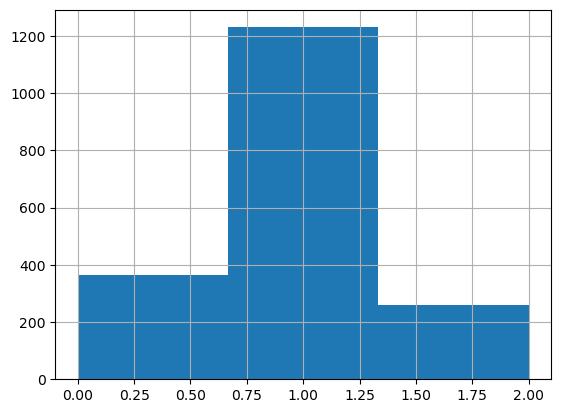

In [2]:
classesList = ['andere','factuur','aanmaning']

Dataset = pd.read_csv(os.getcwd() + "\\test_extraction_emails.csv")
Dataset['classIndex'].hist(bins=3)
print(Dataset.columns)
Dataset = Dataset.drop(['Unnamed: 0','names'],axis=1)
print(Dataset.columns)

def binaryDataset(dataset):
    dataset.loc[dataset['classIndex'] == 2, 'classIndex'] = 1
    return dataset

def reducedDataset(dataset):
    dataset = dataset.drop(dataset[dataset['classIndex'] == 0].index,axis=0)
    dataset.loc[dataset['classIndex'] == 1, 'classIndex'] = 0
    dataset.loc[dataset['classIndex'] == 2, 'classIndex'] = 1
    return dataset

primaryDataset = binaryDataset(Dataset.copy())
secondaryDataset = reducedDataset(Dataset.copy())

print(primaryDataset['classIndex'].unique())
print(secondaryDataset['classIndex'].unique())

### Split dataset into train/test set

In [3]:
primaryTrainSet, primaryEvalSet = train_test_split(primaryDataset, test_size=0.25, stratify=primaryDataset['classIndex'], random_state=42)
secondaryTrainSet, secondaryEvalSet = train_test_split(secondaryDataset, test_size=0.4, stratify=secondaryDataset['classIndex'], random_state=42)
primaryValSet, primaryTestSet = train_test_split(primaryEvalSet, test_size=0.25, stratify=primaryEvalSet['classIndex'], random_state=42)
secondaryValSet, secondaryTestSet = train_test_split(secondaryEvalSet, test_size=0.4, stratify=secondaryEvalSet['classIndex'], random_state=42)

### Define helper functions and variables

In [4]:
#check if CUDA capable gpu is available
cudaAvailable = torch.cuda.is_available()

def calculate_class_weights(trainingDataset):
    weightList = []
    numberOfLabels = len(trainingDataset['classIndex'].unique())
    for i in range(0,numberOfLabels):
        weight = len(trainingDataset.index) / (numberOfLabels * len(trainingDataset[trainingDataset['classIndex'] == i].index))
        weightList.append(weight)
    print(weightList)
    return weightList

# Define model/sweep and start training (pre-classifier)

In [5]:
sweepConfig = {'method' : 'grid', 'parameters' : {'num_train_epochs' : {'min' : 3, 'max' : 5}, 'learning_rate' : {'values' : [4e-5,5e-5,6e-5]}, 'train_batch_size' : {'values' : [16,32]}}}
sweepID = wandb.sweep(sweepConfig, project='Test sweep')

def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

def train():
    wandb.init()
    trainArgumentsSweep = {'reprocess_input_data' : True, 'use_multiprocessing' : True, 'overwrite_output_dir' : True, 'use_early_stopping' : True, 'early_stopping_consider_epochs' : True, 'optimizer' : 'AdamW', 'save_model_every_epoch' : False, 'wandb_project' : 'Test sweep pre classifier'}
    classifierSweep = ClassificationModel("bert","GroNLP/bert-base-dutch-cased", num_labels=len(primaryTrainSet['classIndex'].unique()),args=trainArgumentsSweep, use_cuda=True, weight=calculate_class_weights(primaryTrainSet), sweep_config=wandb.config)
    classifierSweep.train_model(primaryTrainSet)
    result, model_outputs, wrong_predictions = classifierSweep.eval_model(primaryTestSet, f1=f1_multiclass, confusionMatrix=confusion_matrix)
    wandb.log({'mcc' : result['mcc'], 'f1' : result['f1'], 'confusion_matrix' : result['confusionMatrix']})
    wandb.join()
    
wandb.agent(sweepID, train)

Create sweep with ID: mcxfu8so
Sweep URL: https://wandb.ai/spacehack100/Test%20sweep/sweeps/mcxfu8so


wandb: Agent Starting Run: 1dr4pzwq with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 16
wandb: Currently logged in as: spacehack100. Use `wandb login --relogin` to force relogin


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/105 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.


Training loss,▅▃▃█▁▁
f1,▁
global_step,▁▂▄▅▇█
lr,█▇▅▄▂▁
mcc,▁
Training loss,0.01439
f1,0.95699
global_step,300
lr,0.0
mcc,0.86505


wandb: Agent Starting Run: 3whlraic with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 32


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,█▂▁
f1,▁
global_step,▁▅█
lr,█▅▁
mcc,▁
Training loss,0.12886
f1,0.91935
global_step,150
lr,0.0
mcc,0.74447


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: skyzejmo with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 16


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,█▃▄▃▄▃▁▁
f1,▁
global_step,▁▂▃▄▅▆▇█
lr,█▇▆▅▄▃▂▁
mcc,▁
Training loss,0.00057
f1,0.94086
global_step,400
lr,0.0
mcc,0.80971


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4eylz36o with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 32


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,█▄▁▁
f1,▁
global_step,▁▃▆█
lr,█▆▃▁
mcc,▁
Training loss,0.06726
f1,0.94086
global_step,200
lr,0.0
mcc,0.80678


wandb: Agent Starting Run: hh2ad9vt with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 16


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,▃▂▂▇█▁▁▁▁▁
f1,▁
global_step,▁▂▃▃▄▅▆▆▇█
lr,█▇▆▆▅▄▃▃▂▁
mcc,▁
Training loss,0.00149
f1,0.94086
global_step,500
lr,0.0
mcc,0.81265


wandb: Agent Starting Run: n4h8f2pn with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 32


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,▅▄█▁▁
f1,▁
global_step,▁▃▅▆█
lr,█▆▅▃▁
mcc,▁
Training loss,0.00214
f1,0.95161
global_step,250
lr,0.0
mcc,0.84456


wandb: Agent Starting Run: 3pd4i4vo with config:
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 16


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/105 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,█▃▄▁▃▁
f1,▁
global_step,▁▂▄▅▇█
lr,█▇▅▄▂▁
mcc,▁
Training loss,0.0744
f1,0.94086
global_step,300
lr,0.0
mcc,0.81265


wandb: Agent Starting Run: pedyx5n8 with config:
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 32


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,▂█▁
f1,▁
global_step,▁▅█
lr,█▄▁
mcc,▁
Training loss,0.0691
f1,0.93011
global_step,150
lr,0.0
mcc,0.77856


wandb: Agent Starting Run: 6elpqxiq with config:
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 16


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,▂█▁▂▁▁▁▁
f1,▁
global_step,▁▂▃▄▅▆▇█
lr,█▇▆▅▄▃▂▁
mcc,▁
Training loss,0.00046
f1,0.91935
global_step,400
lr,0.0
mcc,0.73354


wandb: Agent Starting Run: nsyfh4lr with config:
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 32


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,█▄▇▁
f1,▁
global_step,▁▃▆█
lr,█▆▃▁
mcc,▁
Training loss,0.00887
f1,0.94086
global_step,200
lr,0.0
mcc,0.80971


wandb: Agent Starting Run: t17l4g8h with config:
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 16


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,▄▃▃▁█▁▁▁▁▁
f1,▁
global_step,▁▂▃▃▄▅▆▆▇█
lr,█▇▆▆▅▄▃▃▂▁
mcc,▁
Training loss,0.00039
f1,0.96237
global_step,500
lr,0.0
mcc,0.8794


wandb: Agent Starting Run: iwkbw2ha with config:
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 32


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,▇▃█▁▁
f1,▁
global_step,▁▃▅▆█
lr,█▆▄▃▁
mcc,▁
Training loss,0.00115
f1,0.93548
global_step,250
lr,0.0
mcc,0.79095


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6opm9i3t with config:
wandb: 	learning_rate: 6e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 16


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/105 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,▄▅▃██▁
f1,▁
global_step,▁▂▄▅▇█
lr,█▇▅▄▂▁
mcc,▁
Training loss,0.0034
f1,0.93011
global_step,300
lr,0.0
mcc,0.77486


wandb: Agent Starting Run: 8boms3dc with config:
wandb: 	learning_rate: 6e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 32


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,█▂▁
f1,▁
global_step,▁▅█
lr,█▅▁
mcc,▁
Training loss,0.01151
f1,0.93548
global_step,150
lr,0.0
mcc,0.79095


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 90a47kzc with config:
wandb: 	learning_rate: 6e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 16


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,▇█▄▆▁▁▁▁
f1,▁
global_step,▁▂▃▄▅▆▇█
lr,█▇▆▅▄▃▂▁
mcc,▁
Training loss,0.00069
f1,0.94624
global_step,400
lr,0.0
mcc,0.82621


wandb: Agent Starting Run: kweysoqt with config:
wandb: 	learning_rate: 6e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 32


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,▇█▁▂
f1,▁
global_step,▁▃▆█
lr,█▆▃▁
mcc,▁
Training loss,0.11668
f1,0.93548
global_step,200
lr,0.0
mcc,0.79095


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yovuayrt with config:
wandb: 	learning_rate: 6e-05
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 16


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,▂█▂▁▁▁▁▁▁▁
f1,▁
global_step,▁▂▃▃▄▅▆▆▇█
lr,█▇▆▆▅▄▃▃▂▁
mcc,▁
Training loss,0.00027
f1,0.95699
global_step,500
lr,0.0
mcc,0.86276


wandb: Agent Starting Run: 4f5gj29e with config:
wandb: 	learning_rate: 6e-05
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 32


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,▅▄█▁▆
f1,▁
global_step,▁▃▅▆█
lr,█▆▄▃▁
mcc,▁
Training loss,0.28205
f1,0.95699
global_step,250
lr,0.0
mcc,0.86146


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


### Move best result into sepperate model (pre-classifier)

In [5]:
wandb.init()
trainArguments = {'output_dir' : "outputs_pre_classifier/", 'reprocess_input_data' : True, 'use_multiprocessing' : True, 'num_train_epochs' : 5, 'overwrite_output_dir' : True, 'use_early_stopping' : True, 'early_stopping_consider_epochs' : True, 'train_batch_size' : 16, 'optimizer' : 'AdamW', 'save_model_every_epoch' : False, 'logging_steps' : 25, 'learning_rate' : 5e-5, 'wandb_project' : 'Test binary pre-classifier', 'wandb_kwargs' : {'magic' : True}}
preClassifier = ClassificationModel("bert","GroNLP/bert-base-dutch-cased", num_labels=len(primaryTrainSet['classIndex'].unique()),args=trainArguments, use_cuda=True, weight=calculate_class_weights(primaryTrainSet))
preClassifier.train_model(primaryTrainSet)

wandb: Currently logged in as: spacehack100. Use `wandb login --relogin` to force relogin


[2.5383211678832116, 0.6226499552372426]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1391 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/87 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/87 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/87 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/87 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/87 [00:00<?, ?it/s]

(435, 0.19145006334118747)

### Evaluate the resulting model against validation set

In [6]:
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

result, model_outputs, wrong_predictions = preClassifier.eval_model(primaryValSet, f1=f1_multiclass, confusionMatrix=confusion_matrix)
print(result)

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/348 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/44 [00:00<?, ?it/s]

Training loss,███▅▆▁▁▂▂▂▁▁▆▁▁▁▁
global_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
lr,███▇▇▆▆▅▅▄▄▃▃▂▂▁▁
Training loss,0.00066
global_step,425
lr,0.0


wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.


{'mcc': 0.7252218309367977, 'tp': 270, 'tn': 49, 'fp': 20, 'fn': 9, 'auroc': 0.9394317178328399, 'auprc': 0.9819154658843251, 'f1': 0.9166666666666666, 'confusionMatrix': array([[ 49,  20],
       [  9, 270]], dtype=int64), 'eval_loss': 0.9098434773702386}


In [7]:
print(type(wrong_predictions[0]))
for i, x in enumerate(wrong_predictions):
    wrong_predictions[i] = str(wrong_predictions[i])
    #wrong_predictions[i] = re.sub("'","\"",wrong_predictions[i])
print(type(wrong_predictions[0]))
print(wrong_predictions[0])
for i, x in enumerate(wrong_predictions):
    wrong_predictions[i] = ast.literal_eval(wrong_predictions[i])
print(type(wrong_predictions[0]))
wrong_predictions_df = pd.DataFrame(wrong_predictions)
wrong_predictions_df = wrong_predictions_df.rename(columns={'guid' : 'testSet_id', 'text_a' : 'text', 'text_b' : 'pred_label', 'label' : 'true_label'})
for i, row in wrong_predictions_df.iterrows():   
    wrong_predictions_df.iloc[i,2] = np.argmax(model_outputs[int(row['testSet_id'])])
wrong_predictions_df

<class 'simpletransformers.classification.classification_utils.InputExample'>
<class 'str'>
{'guid': 16, 'text_a': 'Hey zou het mogelijk zijn onderstaande factuur uit de flow te halen aub Het gaat hier om een ruilfactuur die nu als gewone pending invoice is verwerkt Ik heb dit nu gemerkt omdat ik manueel deze factuur had toegevoegd in de pending invoices en een duplicate invoice melding kreeg image imagepng Alvast bedankt Met vriendelijke groeten Jerry GL accountant image DPG Media Mediaplein Antwerpen JerryExcelmansdpgmediabe dpgmediabe', 'text_b': None, 'label': 0}
<class 'dict'>


testSet_id  \
0           16   
1           50   
2           51   
3           62   
4           65   
5           69   
6           70   
7           76   
8           77   
9           88   
10         108   
11         109   
12         116   
13         123   
14         145   
15         154   
16         155   
17         162   
18         184   
19         186   
20         188   
21         256   
22         259   
23         268   
24         276   
25         287   
26         312   
27         319   
28         335   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

### Evaluate the resulting model against test set

In [8]:
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

result, model_outputs, wrong_predictions = preClassifier.eval_model(primaryTestSet, f1=f1_multiclass, confusionMatrix=confusion_matrix)
print(result)

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/116 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

{'mcc': 0.7300427128296196, 'tp': 85, 'tn': 20, 'fp': 3, 'fn': 8, 'auroc': 0.9387564282374942, 'auprc': 0.9762852842079144, 'f1': 0.9051724137931035, 'confusionMatrix': array([[20,  3],
       [ 8, 85]], dtype=int64), 'eval_loss': 0.45730511584940053}


In [9]:
print(type(wrong_predictions[0]))
for i, x in enumerate(wrong_predictions):
    wrong_predictions[i] = str(wrong_predictions[i])
    #wrong_predictions[i] = re.sub("'","\"",wrong_predictions[i])
print(type(wrong_predictions[0]))
print(wrong_predictions[0])
for i, x in enumerate(wrong_predictions):
    wrong_predictions[i] = ast.literal_eval(wrong_predictions[i])
print(type(wrong_predictions[0]))
wrong_predictions_df = pd.DataFrame(wrong_predictions)
wrong_predictions_df = wrong_predictions_df.rename(columns={'guid' : 'testSet_id', 'text_a' : 'text', 'text_b' : 'pred_label', 'label' : 'true_label'})
for i, row in wrong_predictions_df.iterrows():   
    wrong_predictions_df.iloc[i,2] = np.argmax(model_outputs[int(row['testSet_id'])])
wrong_predictions_df

<class 'simpletransformers.classification.classification_utils.InputExample'>
<class 'str'>
{'guid': 3, 'text_a': 'Dear Partner Please be so kind to share the payment date of below invoices asap Sincerely OKSANA GRYSHCHENKO Phone From GRYSHCHENKO Oksana BCSFIN Sent September To pascalesegersdpgmediabe Vincent Coessens suppliersdpgmediabe Subject RE Payment Reminder Mobile Vikings nv YMEDIALBE Dear Partner good morning Please kindly provide the payment date of below invoices asap Invoice Net due date Amount in doc curr Document currency Text EUR XXXXXXXXXXX EUR DATASMS EUR XXXXXXXXXXX EUR Fraudguard EUR CAPABUND EUR BUNDLED EUR RT EUR RTC EUR DCH Sincerely OKSANA GRYSHCHENKO Phone From GRYSHCHENKO Oksana BCSFIN Sent September To pascalesegersdpgmediabe Vincent Coessens suppliersdpgmediabe Subject RE Payment Reminder Mobile Vikings nv YMEDIALBE Dear Partner This is an urgent reminder on the payment Sincerely OKSANA GRYSHCHENKO Phone From GRYSHCHENKO Oksana BCSFIN Sent September To pascal

testSet_id  \
0            3   
1            9   
2           19   
3           54   
4           63   
5           66   
6           71   
7           77   
8           83   
9           95   
10         103   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

### Save model localy

# Pre-classifier with one-class SVM

In [15]:
print(primaryTrainSet.isna().sum().sum())
print(primaryValSet.isna().sum().sum())
print(primaryTestSet.isna().sum().sum())
primaryTrainSet = primaryTrainSet.dropna()
primaryValSet = primaryValSet.dropna()
primaryTestSet = primaryTestSet.dropna()

primaryTrainSet.loc[primaryTrainSet['classIndex'] == 0, 'classIndex'] = -1
primaryValSet.loc[primaryValSet['classIndex'] == 0, 'classIndex'] = -1
primaryTestSet.loc[primaryTestSet['classIndex'] == 0, 'classIndex'] = -1
primaryTrainText = primaryTrainSet['contents'].tolist()
primaryTrainLabel = primaryTrainSet['classIndex'].tolist()
primaryValText = primaryValSet['contents'].tolist()
primaryValLabel = primaryValSet['classIndex'].tolist()
primaryTestText = primaryTestSet['contents'].tolist()
primaryTestLabel = primaryTestSet['classIndex'].tolist()

vectorizer = TfidfVectorizer()
trainVectors = vectorizer.fit_transform(primaryTrainText)
valVectors = vectorizer.transform(primaryValText)
testVectors = vectorizer.transform(primaryTestText)

GarbageSeperator = OneClassSVM(gamma='auto')
GarbageSeperator.fit(trainVectors)

valPredictions = GarbageSeperator.predict(valVectors)
print('f1 score: ', f1_score(primaryValLabel,valPredictions, average='micro'))
print('mcc score: ', matthews_corrcoef(primaryValLabel,valPredictions))
print(confusion_matrix(primaryValLabel,valPredictions))

testPredictions = GarbageSeperator.predict(testVectors)
print('f1 score: ', f1_score(primaryTestLabel,testPredictions, average='micro'))
print('mcc score: ', matthews_corrcoef(primaryTestLabel,testPredictions))
print(confusion_matrix(primaryTestLabel,testPredictions))

4
2
1
f1 score:  0.5924855491329479
mcc score:  -0.04561177086979459
[[ 19  50]
 [ 91 186]]
f1 score:  0.7043478260869566
mcc score:  0.011707322644771175
[[ 4 19]
 [15 77]]


Doesn't work well for this scenario (low f1 and extremely low mcc -> very random)

# Define model/sweep and start training (multiclass)

In [ ]:
sweepConfig = {'method' : 'grid', 'parameters' : {'num_train_epochs' : {'min' : 3, 'max' : 5}, 'learning_rate' : {'values' : [4e-5,5e-5,6e-5]}, 'train_batch_size' : {'values' : [16,32]}}}
sweepID = wandb.sweep(sweepConfig, project='Test sweep')

def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

def train():
    wandb.init()
    trainArgumentsSweep = {'reprocess_input_data' : True, 'use_multiprocessing' : True, 'overwrite_output_dir' : True, 'use_early_stopping' : True, 'early_stopping_consider_epochs' : True, 'optimizer' : 'AdamW', 'save_model_every_epoch' : False, 'wandb_project' : 'Test sweep'}
    classifierSweep = ClassificationModel("bert","GroNLP/bert-base-dutch-cased", num_labels=len(secondaryTrainSet['classIndex'].unique()),args=trainArgumentsSweep, use_cuda=True, weight=calculate_class_weights(secondaryTrainSet), sweep_config=wandb.config)
    classifierSweep.train_model(secondaryTrainSet)
    result, model_outputs, wrong_predictions = classifierSweep.eval_model(secondaryTestSet, f1=f1_multiclass, confusionMatrix=confusion_matrix)
    wandb.log({'mcc' : result['mcc'], 'f1' : result['f1'], 'confusion_matrix' : result['confusionMatrix']})
    wandb.join()
    
wandb.agent(sweepID, train)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: sw2jrb0y
Sweep URL: https://wandb.ai/spacehack100/Test%20sweep/sweeps/sw2jrb0y


wandb: Agent Starting Run: vwxedsqv with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 16
wandb: WARNING wandb.init() arguments ignored because wandb magic has already been initialized


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/105 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,█▇▁▅▂▁
f1,▁
global_step,▁▂▄▅▇█
lr,█▇▅▄▂▁
mcc,▁
Training loss,0.02284
f1,0.93548
global_step,300
lr,0.0
mcc,0.79095


wandb: Agent Starting Run: s749c59o with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 32


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,█▄▁
f1,▁
global_step,▁▅█
lr,█▅▁
mcc,▁
Training loss,0.01054
f1,0.94086
global_step,150
lr,0.0
mcc,0.81642


wandb: Agent Starting Run: h3m7onsf with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 16


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

### Move best result into sepperate model (multiclass)

In [10]:
wandb.init()
trainArguments = {'output_dir' : "outputs_pre_classifier/", 'reprocess_input_data' : True, 'use_multiprocessing' : True, 'num_train_epochs' : 3, 'overwrite_output_dir' : True, 'use_early_stopping' : True, 'early_stopping_consider_epochs' : True, 'train_batch_size' : 16, 'optimizer' : 'AdamW', 'save_model_every_epoch' : False, 'logging_steps' : 25, 'learning_rate' : 6e-5, 'wandb_project' : 'Test binary pre-classifier', 'wandb_kwargs' : {'magic' : True}}
multiClassifier = ClassificationModel("bert","GroNLP/bert-base-dutch-cased", num_labels=len(secondaryTrainSet['classIndex'].unique()),args=trainArguments, use_cuda=True, weight=calculate_class_weights(secondaryTrainSet))
multiClassifier.train_model(secondaryTrainSet)

wandb: WARNING wandb.init() arguments ignored because wandb magic has already been initialized


[0.6050135501355014, 2.8806451612903228]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/893 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/56 [00:00<?, ?it/s]

(168, 0.2771342479370235)

### Evaluate the resulting model against validation set

In [11]:
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

result, model_outputs, wrong_predictions = multiClassifier.eval_model(secondaryValSet, f1=f1_multiclass, confusionMatrix=confusion_matrix)
print(result)

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/357 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

Training loss,▆█▁▃▂█
global_step,▁▂▄▅▇█
lr,█▇▅▄▂▁
Training loss,0.3755
global_step,150
lr,1e-05


{'mcc': 0.8438490978676872, 'tp': 54, 'tn': 287, 'fp': 8, 'fn': 8, 'auroc': 0.9836796063422636, 'auprc': 0.9173830746762549, 'f1': 0.9551820728291317, 'confusionMatrix': array([[287,   8],
       [  8,  54]], dtype=int64), 'eval_loss': 0.30911252264502564}


In [12]:
print(type(wrong_predictions[0]))
for i, x in enumerate(wrong_predictions):
    wrong_predictions[i] = str(wrong_predictions[i])
    #wrong_predictions[i] = re.sub("'","\"",wrong_predictions[i])
print(type(wrong_predictions[0]))
print(wrong_predictions[0])
for i, x in enumerate(wrong_predictions):
    wrong_predictions[i] = ast.literal_eval(wrong_predictions[i])
print(type(wrong_predictions[0]))
wrong_predictions_df = pd.DataFrame(wrong_predictions)
wrong_predictions_df = wrong_predictions_df.rename(columns={'guid' : 'testSet_id', 'text_a' : 'text', 'text_b' : 'pred_label', 'label' : 'true_label'})
for i, row in wrong_predictions_df.iterrows():   
    wrong_predictions_df.iloc[i,2] = np.argmax(model_outputs[int(row['testSet_id'])])
wrong_predictions_df

<class 'simpletransformers.classification.classification_utils.InputExample'>
<class 'str'>
{'guid': 5, 'text_a': 'Beste Van de bijgevoegde factuur van vinden wij in de boekhouding geen betaling terug Kan u ons meedelen wanneer deze factuur door u betaald werd Ik dank u daarvoor bij voorbaat van harte Met vriendelijke groet Koen Huygebaert Van canonscanhvcobe Verzonden dinsdag augustus Aan Koen Huygebaert HVCO Onderwerp Attached Image', 'text_b': None, 'label': 0}
<class 'dict'>


testSet_id  \
0            5   
1           19   
2           44   
3           50   
4           56   
5           84   
6          106   
7          108   
8          111   
9          149   
10         153   
11         161   
12         201   
13         281   
14         285   
15         306   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

### Evaluate the resulting model against test set

In [13]:
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

result, model_outputs, wrong_predictions = multiClassifier.eval_model(secondaryTestSet, f1=f1_multiclass, confusionMatrix=confusion_matrix)
print(result)

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/239 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/30 [00:00<?, ?it/s]

{'mcc': 0.6118848766315635, 'tp': 25, 'tn': 189, 'fp': 8, 'fn': 17, 'auroc': 0.9523205221174764, 'auprc': 0.84655797403494, 'f1': 0.895397489539749, 'confusionMatrix': array([[189,   8],
       [ 17,  25]], dtype=int64), 'eval_loss': 0.8641438015426198}


In [14]:
print(type(wrong_predictions[0]))
for i, x in enumerate(wrong_predictions):
    wrong_predictions[i] = str(wrong_predictions[i])
    #wrong_predictions[i] = re.sub("'","\"",wrong_predictions[i])
print(type(wrong_predictions[0]))
print(wrong_predictions[0])
for i, x in enumerate(wrong_predictions):
    wrong_predictions[i] = ast.literal_eval(wrong_predictions[i])
print(type(wrong_predictions[0]))
wrong_predictions_df = pd.DataFrame(wrong_predictions)
wrong_predictions_df = wrong_predictions_df.rename(columns={'guid' : 'testSet_id', 'text_a' : 'text', 'text_b' : 'pred_label', 'label' : 'true_label'})
for i, row in wrong_predictions_df.iterrows():   
    wrong_predictions_df.iloc[i,2] = np.argmax(model_outputs[int(row['testSet_id'])])
wrong_predictions_df

<class 'simpletransformers.classification.classification_utils.InputExample'>
<class 'str'>
{'guid': 1, 'text_a': 'Dear SirMadam We still have not received your payment or any further reply Can you please check this with your accounting department If you might have any problems with regard to this invoice please contact us immediately so we can solve the issue If your payment has been arranged already please disregard this message Thank you in advance for your cooperation Kind regards Vronique Imming Accounts Receivable wwwambaflexcom From CreditcontrolEMEA Sent dinsdag augustus To suppliersdpgmediabe Subject Overdue Ambaflex invoice Dear SirMadam Please note that the enclosed invoice is currently outstanding on the AmbaFlex BV account Can you please check this with your accounts and inform us about the status of payment We look forward to receiving your payment accordingly Thank you for your cooperation and kind regards Vronique Imming Accounts Receivable PS If this is not the correct

,testSet_id,text,pred_label,true_label
0,1,Dear SirMadam We still have not received your payment or any further reply Can you please check this with your accounting department If you might have any problems with regard to this invoice please contact us immediately so we can solve the issue If your payment has been arranged already please disregard this message Thank you in advance for your cooperation Kind regards Vronique Imming Accounts Receivable wwwambaflexcom From CreditcontrolEMEA Sent dinsdag augustus To suppliersdpgmediabe Subject Overdue Ambaflex invoice Dear SirMadam Please note that the enclosed invoice is currently outstanding on the AmbaFlex BV account Can you please check this with your accounts and inform us about the status of payment We look forward to receiving your payment accordingly Thank you for your cooperation and kind regards Vronique Imming Accounts Receivable PS If this is not the correct email address for invoices please inform us LinkedIn Twitter YouTube GooglePlus wwwambaflexcom,0,1
1,10,Hallo is het mogelijk onderstaande factuur in de flow te krijgen opdat ze dringend betaald kan worden Alvast bedankt Groeten Tijl Tijl Sacr Director Integreate image Integreate Creative HUB DPG Media Advertising Medialaan Vilvoorde M tijlsacredpgmediabe dpgmediabe image DPG Media Forwarded message Van Marika Miserez Date wo aug om Subject lefaccom Benelux Factuur tweede herinnering To Tijl Sacr Geachte We hopen dat alles goed gaat met u en uw team We komen bij u terug omdat we op u een herinnering stuurden ivm de onbetaalde factuur zie bijlage Voor onze verleende diensten vragen wij u zo snel mogelijk de volgende betaling te voldoen Met vriendelijke groeten Marika Miserez Administrative Assistant TBS group Belgium Avenue Louise Louizalaan Brussels Tel wwwtbsgroupeuropecom wwwlefaccom,1,0
2,26,Dear Customer Please find attached Statement of Account SOA for your company with all open transactions as of Please note that the listing shows all transactions currently open in our systems which may include transactions paid recently promised to be paid or disputed With the exception of disputed transactions please remit payment by the due date Note Did you know that Dell offers the ability to download copies of invoices and view your accounts financial transactionsstatements online Available for select countries Go to to find out more Should you have any questions please reply directly to this email to reach out to your collector AIliescuDellcom Sincerely Dell Collections Team,0,1
3,28,Beste We hebben een aanpassing gedaan in ons programma Vanaf nu zal de factuur ook een link bevatten Deze zouden jullie wel moeten kunnen openen Mocht het toch niet zo zijn laat me gerust iets weten Ik zal zo meteen factuur hersturen en dan kunnen jullie het checken Bij verdere vragen contacteer ons gerust Met vriendelijke groeten Marjan Op ma aug om schreef RPA Suppliers geen factuur in bijage noch link On Sun Aug at EntityOne wrote Date Sun Aug MessageID MIMEVersion ContentType multipartmixed XMailer Microsoft Outlook XReceived by with SMTP id Sat Aug PDT XReceived by with SMTP id Sat Aug PDT XReceived by with SMTP id Sat Aug PDT AuthenticationResults mxgooglecom dkimpass headerientityonebe arcpass spfpass spfdomainemailentityonebe dkimpass dkdomainentityonebe spffail googlecom domain of dpgmediabeemailentityonebe does not designate as permitted sender dpgmediabeemailentityonebe XGoogleDKIMSignature crelaxedrelaxed hxgmmessagestatedkimsignaturedatefrommimeversionmessageid subjectreplytoto PDDg XGmMessageState XGoogleSmtpSource ThreadIndex XSGEID XSGID XEntityID XOlkEid XTeamleaderMail true This is a multipart message in MIME format ContentType multipartalternative ContentType textplain charsetusascii ContentTransferEncoding Beste In bijlage vind je factuur voor onze geleverde diensten Gelieve het vermelde bedrag over te maken voor Contacteer ons gerust via dit emailadres als je nog vragen of opmerkingen hebt Vriendelijke groeten Het Entit

# Conclusion:
BERTje is able to classify emails with high accuracy and percision, but is significantly slower to train or use inference on. However, this can be mitigated by using a more powerfull gpu (at least for training)
- Avg training time with Nvidia RTX 3070 mobile (at 100W tdp) = ~8 seconds per epoch (batch size of 64)
- Avg training time with Nvidia Quadro t1000 mobile (at 50W tdp) = ~7-8 minutes per epoch (batch size of 16)

Conclusion on data: accuracy is heavily influenced by the amount -> each category will need a lot off data

# Sources:
- https://www.philschmid.de/bert-text-classification-in-a-different-language
- https://huggingface.co/GroNLP/bert-base-dutch-cased
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html
- https://huggingface.co/docs/transformers/perf_train_gpu_one
- https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights
- https://stackoverflow.com/questions/60462444/one-class-svm-model-for-text-classification-scikit-learn

# License

BERTje: de Vries, W., van Cranenburgh, A., Bisazza, A., Caselli, T., van Noord, G., & Nissim, M. (2019, December 19). BERTje: A Dutch BERT Model. Groningen, Groningen, Nederland.